In [1]:
import sys
sys.path.append("d:/Documents/Projects/autodrive/modules/")

from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import pandas as pd
import torch
import os
from torchvision.transforms import CenterCrop, Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.models
import torch.optim as optim
from tqdm.auto import tqdm
import gc
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter

random.seed(42)
torch.cuda.manual_seed_all(42)

c:\Users\ANT-PC\anaconda3\envs\autodrive-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 
transformer = Compose([
    Resize((128,128)),
    CenterCrop(128),
    ToTensor(),
    Normalize(mean =[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] )
])

In [3]:
from modules.dataloader import dataloader
from modules.models import create_model
from modules.engine import train_step, test_step

In [4]:
BATCH_SIZE = 32
TEST_SPLIT_RATIO = 0.2
CSV_FILE_PATH = "labels.csv"
CAPTURES_DIR = "captures"

trainloader, testloader = dataloader(csv_file_path="labels.csv", test_set_split_ratio=0.2,
                                     captures_root_dir="captures", transform=transformer, batch_size=BATCH_SIZE, num_workers=2)

In [5]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.float32


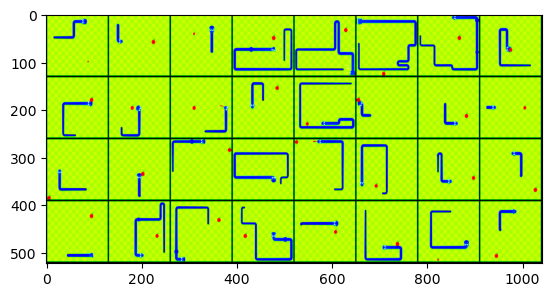

tensor([0, 3, 1, 2, 0, 0, 4, 3, 2, 1, 1, 3, 0, 2, 0, 3, 1, 3, 0, 0, 0, 3, 0, 0,
        2, 0, 0, 0, 4, 2, 0, 4])


In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images[0].dtype)
imshow(torchvision.utils.make_grid(images))
print(labels)
# print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [7]:
import datetime

def create_writer(experiment_name: str, model_name:str, optimizer_name:str, learning_rate,  extra:str="") -> SummaryWriter:
    timestamp= str(datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S"))
    learning_rate = str(learning_rate)
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, optimizer_name,learning_rate, extra).replace("\\", "/")
    return SummaryWriter(log_dir=log_dir)

# Experiment Learning Rate and Optimizer

In [8]:
# import torch.nn as nn
# import torch.optim as optim

# device = "cuda" if torch.cuda.is_available() else "cpu"

# optimizer_names = ["adam", "sgd"]
# learning_rates = [0.001, 0.003, 0.005, 0.007, 0.009]
# epoch_number = 15
# experiment_number = 0
# for optimizer_name in optimizer_names:
#     for learning_rate in learning_rates:
#         experiment_number += 1
#         # print("Experiment Number: ", experiment_number)
#         # print("Optimizer: ", optimizer_name, " Learning Rate: ", learning_rate)
#         model = create_model(model=torchvision.models.efficientnet_v2_s(
#         ), in_features=1280, out_features=5, device=device)
#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate) if optimizer_name == "adam" else optim.SGD(
#             model.parameters(), lr=learning_rate)
#         writer = create_writer(experiment_name=f'{experiment_number}', model_name="effnet_v2_s",
#                                optimizer_name=optimizer_name, learning_rate=learning_rate)

#         for epoch in range(epoch_number):
#             train_loss, train_acc = train_step(
#                 model=model, optimizer=optimizer, criterion=criterion, trainloader=trainloader, epoch=epoch, epoch_number=epoch_number)
#             writer.add_scalar(tag="Training Loss",
#                               scalar_value=train_loss, global_step=epoch)
#             writer.add_scalar(tag="Training Accuracy",
#                               scalar_value=train_acc, global_step=epoch)

#             test_loss, test_acc = test_step(
#                 model=model, criterion=criterion, testloader=testloader)
#             writer.add_scalar(
#                 tag="Test Loss", scalar_value=test_loss, global_step=epoch)
#             writer.add_scalar(tag="Test Accuracy",
#                               scalar_value=test_acc, global_step=epoch)

#         PATH = f'models/{experiment_number}_{optimizer_name}_{learning_rate}'
#         torch.save(model.state_dict(), PATH)


# print('Finished Training')

# Experiment Learning Rate & Epoch

In [ ]:
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# optimizer_names = ["adam", "sgd"]
learning_rates = [0.0007]
epoch_numbers = [35]
model_name = "effnet_v2_m"
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# epoch_number = 15
experiment_number = 0
for epochs in epoch_numbers:
    for learning_rate in learning_rates:
        experiment_number += 1
        # print("Experiment Number: ", experiment_number)
        # print("Optimizer: ", optimizer_name, " Learning Rate: ", learning_rate)
        model = create_model(model=torchvision.models.efficientnet_v2_m(
        ), in_features=1280, out_features=5, device=device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
        writer = create_writer(experiment_name=f'{experiment_number}', model_name=model_name,
                               optimizer_name="adam", learning_rate=learning_rate, extra=str(epochs))

        for epoch in range(epochs):
            train_loss, train_acc = train_step(
                model=model, optimizer=optimizer, criterion=criterion, trainloader=trainloader, epoch=epoch, epoch_number=epochs)
            writer.add_scalar(tag="Training Loss",
                              scalar_value=train_loss, global_step=epoch)
            writer.add_scalar(tag="Training Accuracy",
                              scalar_value=train_acc, global_step=epoch)

            test_loss, test_acc = test_step(
                model=model, criterion=criterion, testloader=testloader)
            writer.add_scalar(
                tag="Test Loss", scalar_value=test_loss, global_step=epoch)
            writer.add_scalar(tag="Test Accuracy",
                              scalar_value=test_acc, global_step=epoch)

        PATH = f'models/{experiment_number}_adam_{model_name}_{learning_rate}_{epochs}.pth'
        torch.save(model.state_dict(), PATH)


print('Finished Training')

In [9]:
# print(loss_container)
# plt.plot(np.linspace(1, epoch_number, epoch_number).astype(int), loss_container)

In [10]:
gc.collect()
torch.cuda.empty_cache()

# Save Model Weights

In [11]:
PATH = 'models/efficientnet_m_snake_small_image_2_balanced_dropout_15_adam.pth'
torch.save(model.state_dict(), PATH)

# Test and Inference

In [12]:
saved_model = torchvision.models.efficientnet_v2_s()
saved_model.classifier =torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=True), torch.nn.Linear(in_features = 1280, out_features = 5)) 
saved_model.load_state_dict(torch.load(PATH))
saved_model = saved_model.to("cuda")
saved_mode = saved_model.eval()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


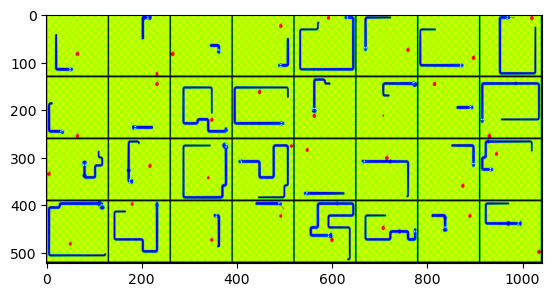

In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
images = images.to("cuda")
labels = labels.to("cuda")

outputs = saved_model(images)
predicted = torch.softmax(outputs, dim=1).argmax(dim = 1)



In [14]:
correct = 0
total = 0
saved_model.eval()
with torch.inference_mode():
  for data in tqdm(trainloader, position = 0, leave = True):
    images,labels = data
    images = images.to("cuda")
    labels = labels.to("cuda")

    outputs = saved_model(images)
    predicted = torch.softmax(outputs, dim=1).argmax(dim = 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  

100%|██████████| 298/298 [00:21<00:00, 13.86it/s]


In [15]:
print(f'\n Accuracy of the network on the training images: {100 * correct // total} %')


 Accuracy of the network on the training images: 90 %


In [16]:
correct = 0
total = 0
with torch.no_grad():
  for data in tqdm(testloader, position = 0, leave = True):
    images,labels = data
    images = images.to("cuda")
    labels = labels.to("cuda")

    outputs = saved_model(images)
    predicted = torch.softmax(outputs, dim=1).argmax(dim = 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  


100%|██████████| 75/75 [00:08<00:00,  8.35it/s]


In [17]:
print(f'\n Accuracy of the network on the test images: {100 * correct // total} %')


 Accuracy of the network on the test images: 76 %
